In [2]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Create the dataframe with the CSV file provided by the company. As the CSV has missing values, we will use onbad_lines='skip'
df = pd.read_csv('marketingcampaigns.csv', on_bad_lines='skip')

In [4]:
#Display the dataframe
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.3,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.1,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.9,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaN,100000,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,abc,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000,0.60,webinar,B2B,paid,0.70,90000.00


In [5]:
# Let's do some basic analysis: such as check the datatypes, the null values and some basic statistics
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name       object
start_date          object
end_date            object
budget              object
roi                float64
type                object
target_audience     object
channel             object
conversion_rate    float64
revenue            float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             3
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,std,min,25%,50%,75%,max
roi,1028.0,0.533804,0.261869,-0.20,0.31,0.53,0.76,0.99
conversion_rate,1028.0,0.541936,0.267353,0.00,0.30,0.55,0.77,1.50
revenue,1029.0,511591.195277,287292.729847,108.21,267820.25,518001.77,765775.14,999712.49


Just by analyzing above data, we can see a few thing we need to take care of:
- We need to make sure that dates are in the correct format (currenly object when it should be datetime).
- We need to make sure budget is in the correct format (currenly object when it should be float).

Before changing anything, let's see what values have the columns that are in the wrong format

In [6]:
# Since budget column should be numeric, let's check if there are any non-numeric values in the Budget column

non_numeric_budget = df[~pd.to_numeric(df['budget'], errors='coerce').notnull()]
print(non_numeric_budget[['budget']])


     budget
1003    NaN
1005    NaN
1024    NaN
1029    abc


In [7]:
# Now let's check date columns. The columns 'start_date' and 'end_date' should be in datetime format. Let's check if they are in the correct format.
non_datetime_start_date	 = df[~pd.to_datetime(df['start_date'], errors='coerce').notnull()]
non_datetime_end_date = df[~pd.to_datetime(df['end_date'], errors='coerce').notnull()]
print(non_datetime_start_date[['start_date']])
print('\n')
print(non_datetime_end_date[['end_date']])

      start_date
1006  2023-13-01
1021         NaN
1022  2023-13-01


        end_date
1006  2024-02-30
1024         NaN
1028         NaN


- Values that are not in the correct format for budget column: 3 nulls and one value which is not part of any of the other columns.
- Values that are not in the correct format for dates columns: 3 nulls, one date which does not exist and 2 dates with the wrong structure (YYY-DD-MM instead of YYYY-MM-DD). 

Knowing this, we can proceed to fix the columns.

In [8]:
# # First step is to check those rows (where the wrong dates are) and check the values so we can take the right decision
df.iloc[[1006, 1022]]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1006,Typo in Date,2023-13-01,2024-02-30,50000.0,0.65,webinar,B2C,promotion,0.9,320000.0
1022,Broken-date campaign,2023-13-01,2024-01-01,25000,0.45,email,B2B,organic,NaN,87500.0


We can see from above table:
- Row 1006: Since the row is fine we take the decision to change the end_date to 2024-03-01. This decision has been taken because is more likely that the end_date is a formula of start_date + X days. We will put the right format on start_date as well.
- Row 1022: Rest of the data is completely fine. We will put the right format on start_date.

In [9]:
# Let's modify the values for rows 1006 and 1022 in "start_date" to get YYYY-MM-DD instead of YYYY-DD-MM 
# and also in row 1006 the value in column end_date to get 2024-03-01 instead of 2024-02-30
df.loc[1006, 'start_date'] = '2024-01-13'
df.loc[1022, 'start_date'] = '2024-01-13'
df.loc[1006, 'end_date'] = '2024-03-01'

Now we can proceed to fix the columns. The only value we will discard in the "abc" on budget column

In [10]:
# Now let's change the format in columns start_date, end_date and budget to the correct format
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

Now, we should have the correct format for all columns. Let's check the datatypes again to make sure everything is in order and also the basic statics we checked before.

In [11]:
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name              object
start_date         datetime64[ns]
end_date           datetime64[ns]
budget                    float64
roi                       float64
type                       object
target_audience            object
channel                    object
conversion_rate           float64
revenue                   float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             4
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,min,25%,50%,75%,max,std
start_date,1031,2023-01-31 06:29:40.795344384,2022-08-02 00:00:00,2022-10-31 00:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1030,2024-01-30 01:49:02.912621312,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-27 12:00:00,2024-05-03 18:00:00,2025-06-01 00:00:00,NaN
budget,1028.0,58995.980506,-10000.0,24735.4925,46948.235,74923.65,9999999.0,311694.946084
roi,1028.0,0.533804,-0.2,0.31,0.53,0.76,0.99,0.261869
conversion_rate,1028.0,0.541936,0.0,0.3,0.55,0.77,1.5,0.267353
revenue,1029.0,511591.195277,108.21,267820.25,518001.77,765775.14,999712.49,287292.729847


Now the dataset looks much better, and we have only one more null (the old "abc" value in budget column). 

In [12]:
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000.00,0.60,webinar,B2B,paid,0.70,90000.00


Let's check now all values:
- end_date must be after start_date.
- Categoric values must have the correct values (no mixed values).

In [13]:
# Let's check end_date is greater than start_date.
df_dates_check = df[df['end_date'] < df['start_date']]
df_dates_check

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1022,Broken-date campaign,2024-01-13,2024-01-01,25000.0,0.45,email,B2B,organic,NaN,87500.0
1030,Overlapping dates,2023-03-01,2022-12-31,60000.0,0.60,webinar,B2B,paid,0.7,90000.0


So we can see there are two lines where the start_date is after the end_date. Let's check now the categoric values.

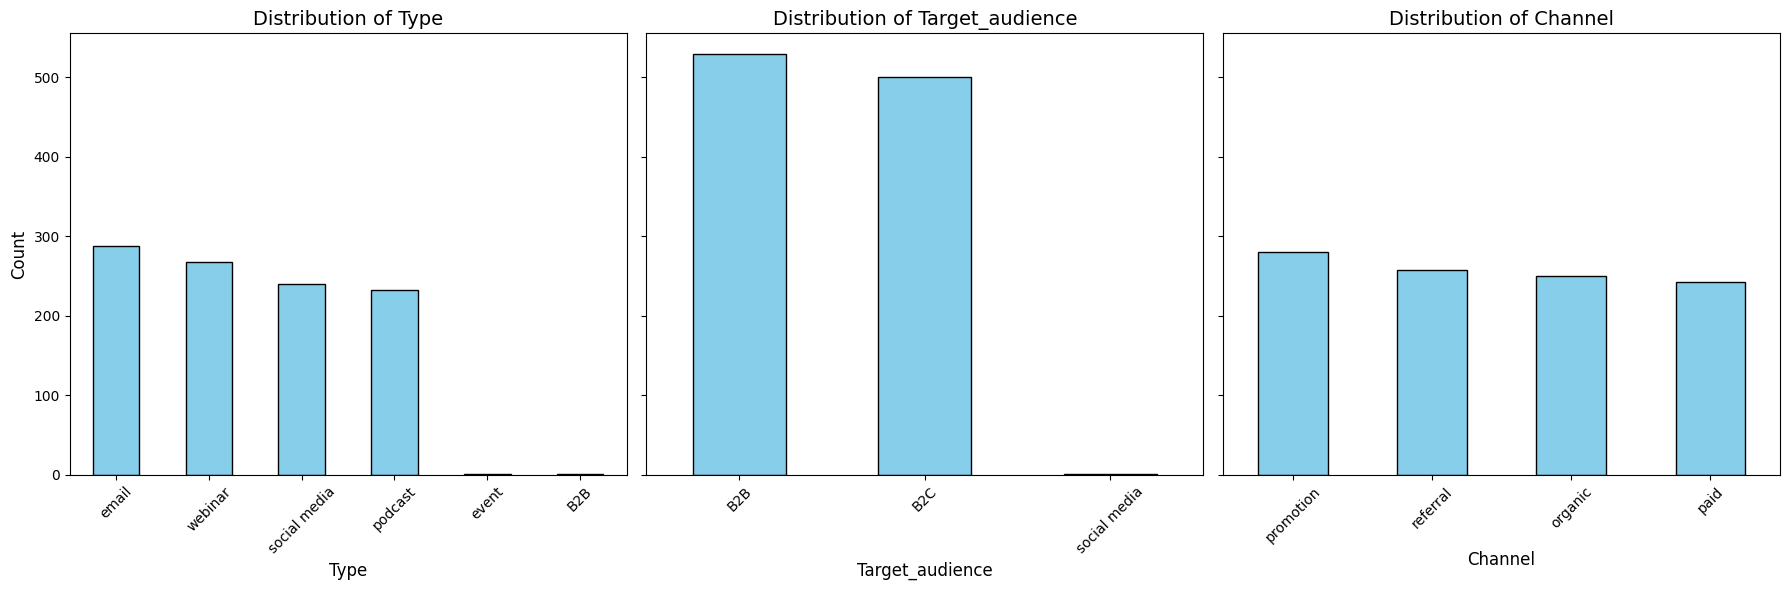

In [14]:
# Let's use a bar plot to visualize the distribution of the categorical columns in the dataset. 
# Then we can focus on those which have a lower number of values to check if they really belong to that column.

categorical_columns = ['type', 'target_audience', 'channel']

fig, axes = plt.subplots(1, len(categorical_columns), figsize=(18, 6), sharey=True)

for i, col in enumerate(categorical_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col.capitalize()}', fontsize=14)
    axes[i].set_xlabel(col.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Having a quick look at the date, it is easy to identify some mistakes: there is a "social media" value in the target_audience column and a "B2B" value in the Type column. Also, there is one value in the type column which is used only once: "event".
Let's analyze them

In [15]:
# Let's see the rows with the unique value in column 'type'
df_filtered1 = df[df['type'] == 'event']
df_filtered1

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1021,Cloud-based scalable solution,NaT,2023-12-31,50000.0,NaN,event,B2C,paid,0.3,120000.0


In [16]:
# Let's see the rows with the wrong values in the column 'type'
df_filtered2 = df[df['type'] == 'B2B']
df_filtered2

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1024,Null-heavy campaign,2023-01-01,NaT,NaN,NaN,B2B,social media,NaN,NaN,NaN


We can see that the row which contains the wrong value in the column 'type' is the same that contains the wrong value in the column 'target_audience'.

So far, as a summary, we have:
- 2 rows with the start_date after the end_date.
- 1 row with the values interchanged which is not providing any value at all since the rest of the values are null. Therefore we will drop this row.

In [17]:
# We will drop row 1024
df1 = df.drop(index=1024)

Now let's check if there are duplicated rows.

In [18]:
# Let's check duplicate rows in the dataset
duplicates = df1[df1.duplicated(keep=False)]
duplicates.sort_values(by='campaign_name', ascending=True)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1001,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
1011,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
11,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1020,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1010,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1002,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1012,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73


In [19]:
# Let's count the duplicated rows
duplicates_count = df1.duplicated(keep=False).sum()
duplicates_count

np.int64(27)

We can see 27 duplicated rows. Let's drop them.

In [20]:
# Let's drop the duplicates rows
df2 = df1.drop_duplicates(keep='first')

In [21]:
df2

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000.00,0.60,webinar,B2B,paid,0.70,90000.00


In [22]:
# Let's see the unique values the categorial columns in the dataset have in order to check if they are consistent
categorical_columns = df2.select_dtypes(include=['object'])

for column in categorical_columns.columns:
    print(f"Unique values in column '{column}':")
    print(categorical_columns[column].unique())
    print()

Unique values in column 'campaign_name':
['Public-key multi-tasking throughput'
 'De-engineered analyzing task-force'
 'Balanced solution-oriented Local Area Network' ... 'Invalid budget'
 'Overlapping dates' 'Too many conversions']

Unique values in column 'type':
['email' 'podcast' 'webinar' 'social media' nan 'event']

Unique values in column 'target_audience':
['B2B' 'B2C' nan]

Unique values in column 'channel':
['organic' 'promotion' 'paid' 'referral']



Now we have a dataset with no duplicates and all columns in the correct format. Let's check the basic statistics again to see what we do with the nulls.

In [23]:
# Let's see the percetange that null values represent by columns
df2.isnull().mean() * 100

campaign_name      0.000000
start_date         0.098425
end_date           0.098425
budget             0.295276
roi                0.295276
type               0.098425
target_audience    0.196850
channel            0.000000
conversion_rate    0.295276
revenue            0.196850
dtype: float64

In [24]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,1015,2023-01-31 02:36:03.546798080,2022-08-02 00:00:00,2022-10-30 12:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1015,2024-01-30 06:52:50.837438720,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-28 00:00:00,2024-05-04 00:00:00,2025-06-01 00:00:00,NaN
budget,1013.0,59264.030395,-10000.0,24959.24,47198.52,74898.2,9999999.0,313966.312578
roi,1013.0,0.535084,-0.2,0.31,0.53,0.77,0.99,0.262657
conversion_rate,1013.0,0.543376,0.0,0.3,0.55,0.77,1.5,0.267734
revenue,1014.0,513344.391292,108.21,268474.4725,519906.22,770016.185,999712.49,287623.39894


<Axes: xlabel='revenue'>

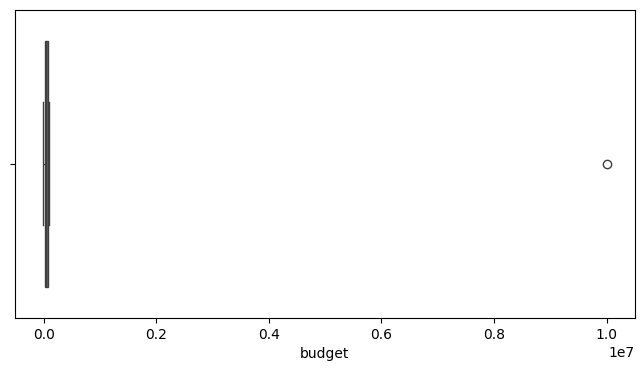

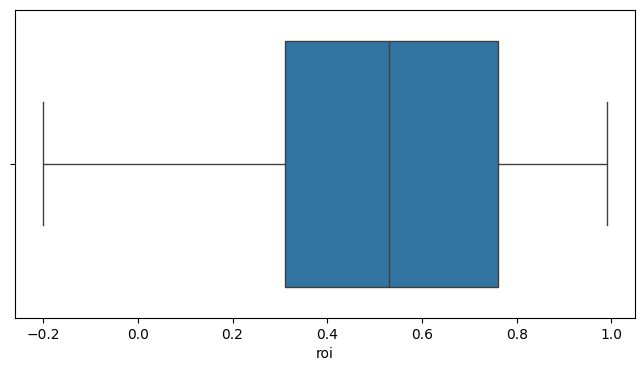

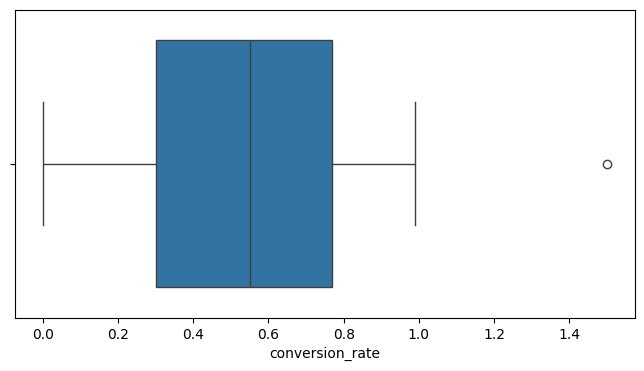

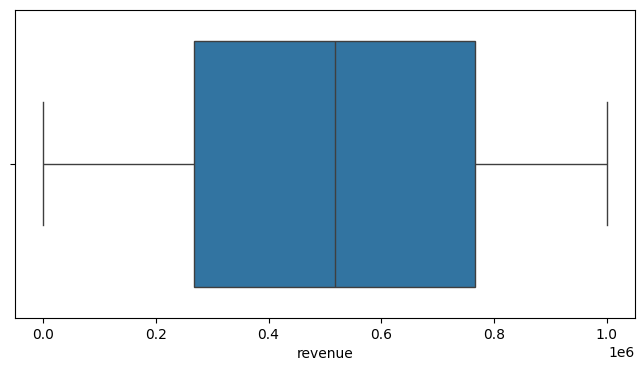

In [25]:
# Generate boxplots for identifying outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['budget'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['roi'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['conversion_rate'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['revenue'])

In [26]:
# Let's reset the index for a better analysis and visualization
df2.reset_index(drop=True, inplace=True)

In [27]:
# With the new index, let's calculate in which rows are the wrong dates
df2_dates_check = df2[df2['end_date'] < df2['start_date']]
df2_dates_check

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.0,0.45,email,B2B,organic,NaN,87500.0
1014,Overlapping dates,2023-03-01,2022-12-31,60000.0,0.60,webinar,B2B,paid,0.7,90000.0


In [28]:
# Let's check the outliers in column 'budget'
outlier_budget_max = df2[df2['budget'] > 9999998]
outlier_budget_min = df2[df2['budget'] < 1000]
outlier_budget_max

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1005,Outlier Budget,2023-07-01,2024-03-01,9999999.0,0.1,email,B2B,promotion,0.2,50000.0


In [29]:
outlier_budget_min

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.0,-0.2,podcast,B2C,referral,0.1,NaN


In [30]:
# We can see that the outlier in column 'budget' is for a 'email' type. 
# Let's see which is the mean and the median of the column 'budget' for the type 'email'
mean_budget_email = df2[df2['type'] == 'email']['budget'].mean()
median_budget_email = df2[df2['type'] == 'email']['budget'].median()
print(f'Mean budget for email type: {mean_budget_email}')
print(f'Median budget for email type: {median_budget_email}')

Mean budget for email type: 84933.9060283688
Median budget for email type: 47778.259999999995


If we compare the mean and the meadian with the budget of row 1005, we can see that the value must be an error.
Row 1008 is an error since the budget cannot be negative.

In [31]:
# Let's check the outlier in column 'conversion_rate'
outlier_conversion_rate = df2[df2['conversion_rate'] > 1]
outlier_conversion_rate

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1015,Too many conversions,2023-05-01,2023-11-01,40000.0,0.8,social media,B2C,organic,1.5,120000.0


The fact that there is only 1 row with a conversion_rate above 1 is a good indicator that this value is an error as well.

In [32]:
# Let's see the row with the unique value in column 'type' again
df2_filtered = df2[df2['type'] == 'event']
df2_filtered

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.0,NaN,event,B2C,paid,0.3,120000.0


In [33]:
#Let's identify the rows with null values in the dataset
null_rows = df2[df2.isnull().any(axis=1)]
null_rows

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1000,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1001,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1002,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.00,NaN,event,B2C,paid,0.30,120000.00
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.00,0.45,email,B2B,organic,NaN,87500.00
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.00,-0.20,podcast,B2C,referral,0.10,NaN
1010,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1011,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1012,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1013,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00


In [34]:
#Let's check if there are is an outlier on the revenue column
filtered_revenue_min = df2[df2['revenue'] < 5000]

filtered_revenue_min

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
14,Innovative web-enabled function,2022-11-05,2023-09-05,36848.30,0.92,webinar,B2C,referral,0.10,4190.95
427,Programmable homogeneous projection,2022-09-24,2023-11-12,11006.30,0.25,podcast,B2C,promotion,0.98,3641.30
889,Grass-roots scalable framework,2023-02-16,2023-08-19,61978.10,0.39,social media,B2C,paid,0.77,108.21
975,Extended 24hour contingency,2023-07-07,2023-08-18,69815.82,0.16,podcast,B2C,organic,0.27,2810.51


We can see value revenue for row 889 is extremely low and it does not make any sense with that budget and ROI, therefore we will calculate the revenue and do the change

In [35]:
filtered_revenue_max = df2[df2['revenue'] > 995000]

filtered_revenue_max

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
170,Realigned radical hardware,2022-11-03,2024-07-12,34512.86,0.20,webinar,B2B,referral,0.87,999712.49
201,Optional mission-critical project,2022-08-06,2024-07-22,96713.47,0.92,podcast,B2C,paid,0.63,995340.62
618,Automated executive moderator,2022-09-03,2024-01-06,65864.61,0.29,social media,B2B,promotion,0.19,999317.92
626,Realigned scalable moderator,2023-04-07,2023-10-03,55780.60,0.54,email,B2B,referral,0.19,996578.25
758,Function-based leadingedge budgetary management,2022-12-16,2023-08-23,64755.70,0.63,webinar,B2B,referral,0.20,996493.10
880,Balanced optimizing software,2023-04-10,2024-05-10,10297.36,0.95,podcast,B2B,paid,0.71,997657.18


So far we have:
- 2 rows (1007, 1014) with the start_date after the end_date.
- 4 outliers: two in the budget column (1005, 1008), one in column revenue (889) and one in the conversion_rate column (1015).
- 1 unique value (1006) in column 'type'
- 7 rows with null values, excluding the ones alread mentioned with other issues (1000, 1001, 1002, 1010, 1011, 1012, 1013).


In [36]:
#Let's check the is we are missing any outlier in the dataset with the IQR method and the Z-score method.
numeric_columns = ['budget', 'roi', 'conversion_rate', 'revenue']

# IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25) 
    Q3 = data[column].quantile(0.75)  
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

# Let's check the outliers in the dataset using both methods
for column in numeric_columns:
    print(f"Outliers in column '{column}' using IQR:")
    outliers_iqr = detect_outliers_iqr(df2, column)
    print(outliers_iqr)
    print(f"\nOutliers in column '{column}' using Z-score:")
    outliers_zscore = detect_outliers_zscore(df2, column)
    print(outliers_zscore)
    print("\n")

Outliers in column 'budget' using IQR:
       campaign_name start_date   end_date     budget  roi   type  \
1005  Outlier Budget 2023-07-01 2024-03-01  9999999.0  0.1  email   

     target_audience    channel  conversion_rate  revenue  
1005             B2B  promotion              0.2  50000.0  

Outliers in column 'budget' using Z-score:
       campaign_name start_date   end_date     budget  roi   type  \
1005  Outlier Budget 2023-07-01 2024-03-01  9999999.0  0.1  email   

     target_audience    channel  conversion_rate  revenue  
1005             B2B  promotion              0.2  50000.0  


Outliers in column 'roi' using IQR:
Empty DataFrame
Columns: [campaign_name, start_date, end_date, budget, roi, type, target_audience, channel, conversion_rate, revenue]
Index: []

Outliers in column 'roi' using Z-score:
Empty DataFrame
Columns: [campaign_name, start_date, end_date, budget, roi, type, target_audience, channel, conversion_rate, revenue]
Index: []


Outliers in column 'conversion

The methods are not providing any extra values we need to take care of.

In [37]:
# Let's see all rows with wrong or missing information / outliers in the dataset
df2.iloc[[889, 1000, 1001, 1002, 1005, 1006, 1007, 1008, 1010, 1011, 1012, 1013, 1014, 1015]]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
889,Grass-roots scalable framework,2023-02-16,2023-08-19,61978.10,0.39,social media,B2C,paid,0.77,108.21
1000,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1001,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1002,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1005,Outlier Budget,2023-07-01,2024-03-01,9999999.00,0.10,email,B2B,promotion,0.20,50000.00
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.00,NaN,event,B2C,paid,0.30,120000.00
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.00,0.45,email,B2B,organic,NaN,87500.00
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.00,-0.20,podcast,B2C,referral,0.10,NaN
1010,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1011,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN


The rows with wrong dates will be dropped because we cannot determine whether the wrong date is the start_date or the end_date. Therefore, we cannot calculate the duration of the campaign or perform any seasonal analysis.

We will drop as well the row with the unique value in the type column since there is no enough information for comparison/analysis.

We will drop as well the outlier with the negative budget since it is not possible to have a negative budget and we don't have a revenue so we can calculate the right budget with the ROI.

In [38]:
# Let's compare the conversion_rate outlier so we can decide if we drop it or modify it

median_conversion_rate = df2[
    (df2['budget'].between(35000, 45000)) &
    (df2['type'] == 'social media') &
    (df2['target_audience'] == 'B2C') &
    (df2['channel'] == 'organic')
]['conversion_rate'].median()

median_conversion_rate

np.float64(0.565)

In [39]:

median_conversion_rate_revenue = df2[
    (df2['budget'].between(35000, 45000)) &
    (df2['type'] == 'social media') &
    (df2['target_audience'] == 'B2C') &
    (df2['channel'] == 'organic')
]['revenue'].median()

median_conversion_rate_revenue

np.float64(742999.9299999999)

After analyzing the median of the conversion_rate and revenue columns, we can see that the outlier in the conversion_rate column is not consistent with the other values in the dataset.
So we will drop it.

Since we have revenue, budget and roi, we should be able to get any of these values if we have the other two:

ROI = (Revenue - Budget) / Budget

In [80]:
# Let's check if the ROI is following the formula above before doing any further calculation
df2['calculated_roi'] = ((df2['revenue'] - df2['budget']) / df2['budget'])

matching_roi = (df2['roi'] == df2['calculated_roi'])

matching_roi_count = matching_roi.sum()

mismatching_roi_count = (~matching_roi).sum()

print(f"Correct ROIs: {matching_roi_count}")
print(f"Wrong ROIs: {mismatching_roi_count}")


Correct ROIs: 0
Wrong ROIs: 1016


C:\Users\ignac\AppData\Local\Temp\ipykernel_14048\859650222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['calculated_roi'] = ((df2['revenue'] - df2['budget']) / df2['budget'])


It looks like the ROI is not matching with the formula, which means we cannot calculate any of these values (probably because the campaigns incurred different costs than the ones included in the budget).

Therefore, we will drop the rows with outliers (889, 1005 and 1008) since they are only 3 rows out of 1016, so it won't affec the analysis. 

In [ ]:
# Let's drop the above mentioned rows and replace the budget outlier.
df2 = df2.drop(columns=['calculated_roi'])
df3 = df2.drop([889, 1005, 1006, 1007, 1008, 1014, 1015])
df3.reset_index(drop=True, inplace=True)
df3

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1004,Future campaign,2025-01-01,2025-06-01,75000.00,0.90,webinar,B2C,promotion,0.65,200000.00
1005,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1006,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1007,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00


Now we have a clean dataset without outliers. Let's take care of the nulls.

In [93]:
# Let's identify the nulls per column
df3.isnull().sum()

campaign_name      0
start_date         0
end_date           1
budget             3
roi                2
type               1
target_audience    2
channel            0
conversion_rate    2
revenue            1
dtype: int64

In [ ]:
# We have 12 nulls, now let's see the information in the rows with null values
df3[df3.isnull().any(axis=1)]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
999,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1000,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1001,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1005,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1006,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1007,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1008,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00


Having a look we can identify the next steps:
- Row 999: we cannot calculate the budget.
- Row 1000: we will analyze similar rows to see which is the most likely value.
- Row 1001: we cannot calculate the budget nor the conversion_rate.
- Row 1005: we will analyze similar rows to see which is the most likely value.
- Row 1006: we cannot calculate the revenue.
- Row 1007: it will be dropped since it has too many nulls.
- Row 1008: it wil be dropped since we canot work without budget nor roi.

For numerical values, since we cannot calculate the missing values and, as a result, cannot verify if the values are correct, we will drop those rows as well.

In [96]:
# Let's do all the changes mentioned above

df4 = df3.drop([999, 1001, 1006, 1007, 1008])
df4.reset_index(drop=True, inplace=True)
df4

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
999,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1000,Typo in Date,2024-01-13,2024-03-01,50000.00,0.65,webinar,B2C,promotion,0.90,320000.00
1001,Duplicate Campaign,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1002,Future campaign,2025-01-01,2025-06-01,75000.00,0.90,webinar,B2C,promotion,0.65,200000.00


Let's work now on the row with the missing value on column type.

In [98]:
# Filter rows with missing values in the 'type' column
missing_type_row = df4[df4['type'].isnull()]

# Identify similar rows based on other columns
similar_rows = df4[
    (df4['budget'].between(missing_type_row['budget'].values[0] - 5000, missing_type_row['budget'].values[0] + 5000)) &
    (df4['roi'].between(missing_type_row['roi'].values[0] - 0.1, missing_type_row['roi'].values[0] + 0.1)) &
    (df4['target_audience'] == missing_type_row['target_audience'].values[0]) &
    (df4['channel'] == missing_type_row['channel'].values[0])
]

# Find the most frequent value in the 'type' column among similar rows
most_likely_type = similar_rows['type'].mode().values[0]

most_likely_type

'email'

In [99]:
missing_type_row

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
999,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.4,NaN,B2C,promotion,0.52,206241.46


Now we have an answer: email type is the mos likely value row 999.

In [100]:
# Let's make the chage
df4.loc[999, 'type'] = most_likely_type

Let's work with the row with the missing value on column target_audience.

In [103]:
missing_target_row = df4[df4['target_audience'].isnull()]
missing_target_row

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1003,Extra long name campaign test,2023-04-15,2023-09-15,30000.0,0.25,email,NaN,paid,0.4,45000.0


In [104]:
# Filter rows with missing values in the 'target_audience' column
missing_target_row = df4[df4['target_audience'].isnull()]


# Identify similar rows based on other columns
target_similar_rows = df4[
    (df4['budget'].between(missing_target_row.iloc[0]['budget'] - 5000, missing_target_row.iloc[0]['budget'] + 5000)) &
    (df4['roi'].between(missing_target_row.iloc[0]['roi'] - 0.1, missing_target_row.iloc[0]['roi'] + 0.1)) &
    (df4['type'] == missing_target_row.iloc[0]['type']) &
    (df4['channel'] == missing_target_row.iloc[0]['channel'])
]

# Find the most frequent value in the 'target_audience' column among similar rows
most_likely_target = target_similar_rows['target_audience'].mode()

most_likely_target

Series([], Name: target_audience, dtype: object)

The analysis is showig there are no similar rows to row 1007.

We will maintain this row because even though it will not provide any value if we want to evaluate the data based on the target_audience, it still can provide value for the rest of fields such as type or channel.

Now we will check if there are any duplicated campaigns.

In [107]:
# Let's identify the campaigns with the same name
duplicated_campaign = df4[df4.duplicated(subset=['campaign_name'], keep=False)]
duplicated_campaign.sort_values(by='campaign_name', ascending=True)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
203,Reverse-engineered static infrastructure,2023-07-26,2024-05-29,12246.32,0.48,email,B2B,referral,0.44,987205.29
984,Reverse-engineered static infrastructure,2023-07-16,2023-08-07,7315.35,0.86,email,B2C,referral,0.70,162798.55
7,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,webinar,B2C,promotion,0.52,206241.46
999,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,email,B2C,promotion,0.52,206241.46


We have two duplicated campaigns. Let's check the values and analyze the differences:
- For campaign "Reverse-engineered static infrastructure", only columns type and channel are the same.
- For campaign "User-friendly client-driven service-desk" all data is duplicated except the type.

In [108]:
# For "Reverse-engineered static infrastructure" we have the same values for type and channel.
# Let's see which is the average duration and the average budget for campais with those values.
filteredB2B_df4 = df4[
    (df4['type'] == 'email') &
    (df4['target_audience'] == 'B2B') &
    (df4['channel'] == 'referral')]

filteredB2B_df4['duration_days'] = (filteredB2B_df4['end_date'] - filteredB2B_df4['start_date']).dt.days

mean_durationB2B = filteredB2B_df4['duration_days'].mean()
median_durationB2B = filteredB2B_df4['duration_days'].median()
mean_budgetB2B = filteredB2B_df4['budget'].mean()
median_budgetB2B = filteredB2B_df4['budget'].median()


print(f"Duration mean : {mean_durationB2B:.2f}")
print(f"Duration median : {median_durationB2B:.2f}")
print(f"Budget mean : {mean_budgetB2B:.2f}")
print(f"Budget meadian : {median_budgetB2B:.2f}")

Duration mean : 378.19
Duration median : 371.00
Budget mean : 49776.96
Budget meadian : 44251.43


C:\Users\ignac\AppData\Local\Temp\ipykernel_14048\3214737685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredB2B_df4['duration_days'] = (filteredB2B_df4['end_date'] - filteredB2B_df4['start_date']).dt.days


In [109]:
# For "Reverse-engineered static infrastructure" we have the same values for type and channel.
# Let's see which is the average duration and the average budget for campais with those values.
filteredB2C_df4 = df4[
    (df4['type'] == 'email') &
    (df4['target_audience'] == 'B2C') &
    (df4['channel'] == 'referral')]

filteredB2C_df4['duration_days'] = (filteredB2C_df4['end_date'] - filteredB2C_df4['start_date']).dt.days

mean_durationB2C = filteredB2C_df4['duration_days'].mean()
median_durationB2C = filteredB2C_df4['duration_days'].median()
mean_budgetB2C = filteredB2C_df4['budget'].mean()
median_budgetB2C = filteredB2C_df4['budget'].median()


print(f"Duration mean : {mean_durationB2C:.2f}")
print(f"Duration median : {median_durationB2C:.2f}")
print(f"Budget mean : {mean_budgetB2C:.2f}")
print(f"Budget meadian : {median_budgetB2C:.2f}")

Duration mean : 352.88
Duration median : 364.50
Budget mean : 48048.48
Budget meadian : 39659.11


C:\Users\ignac\AppData\Local\Temp\ipykernel_14048\2184526943.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredB2C_df4['duration_days'] = (filteredB2C_df4['end_date'] - filteredB2C_df4['start_date']).dt.days


If we analyze the differences between the B2C and B2B in relation to the duration days of the campaign and the budget, we can see there is no much difference. But we have a really big difference in the dataset (307 days on row 203 against 22 days on row 984). Therefore we will drop row 984.

In [111]:
df4.dtypes

campaign_name              object
start_date         datetime64[ns]
end_date           datetime64[ns]
budget                    float64
roi                       float64
type                       object
target_audience            object
channel                    object
conversion_rate           float64
revenue                   float64
dtype: object

In [112]:
# Now let's analyze campaign "User-friendly client-driven service-desk"
# Filter rows with the same values (except the type)

check_type_row = df4.iloc[7]

# Identify similar rows based on other columns
type_similar_rows = df4[
    (df4['budget'].between(check_type_row['budget'] - 5000, check_type_row['budget'] + 5000)) &
    (df4['target_audience'] == check_type_row['target_audience']) &
    (df4['channel'] == check_type_row['channel'])
]

# Find the most frequent value in the 'type' column among similar rows
most_likely_type2 = type_similar_rows['type'].mode().values[0]

most_likely_type2

'email'

The most likely value for those values is "email" for type column, therefore we will drop row 7

In [113]:
df5 = df4.drop([7, 984])
df5.reset_index(drop=True, inplace=True)
df5

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
997,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,email,B2C,promotion,0.52,206241.46
998,Typo in Date,2024-01-13,2024-03-01,50000.00,0.65,webinar,B2C,promotion,0.90,320000.00
999,Duplicate Campaign,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1000,Future campaign,2025-01-01,2025-06-01,75000.00,0.90,webinar,B2C,promotion,0.65,200000.00


Now we have out dataset ready. Let's do a recap of what we have done:
- We have fixed the formats (df).
- We have removed the line that had some values interchanged and a lot of missing values (df1).
- We have removed duplicate rows (df2).
- We have take care of the outliers (df3).
- We have take care of null values (df4 and df5).
- We have removed partial duplicate rows (df6).

In [115]:
# Let's do some analysis in order to see the impact our data clean has had.
# We will start with some basic figures:
print(f"Original database (df): {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Final database (df5): {df5.shape[0]} rows, {df5.shape[1]} columns")

print(f"Null values in df:\n{df.isnull().sum()}")
print(f"Null values in df5:\n{df5.isnull().sum()}")

print(f"Unique values in 'target_audience' at df: {df['target_audience'].nunique()}")
print(f"Unique values in 'target_audience' at df5: {df5['target_audience'].nunique()}")

print(f"Unique values in 'channel' at df: {df['channel'].nunique()}")
print(f"Unique values in 'channel' at df5: {df5['channel'].nunique()}")

print(f"Unique values in 'type' at df: {df['type'].nunique()}")
print(f"Unique values in 'type' at df5: {df5['type'].nunique()}")

Original database (df): 1032 rows, 11 columns
Final database (df5): 1002 rows, 10 columns
Null values in df:
campaign_name      0
start_date         1
end_date           2
budget             4
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
calculated_roi     6
dtype: int64
Null values in df5:
campaign_name      0
start_date         0
end_date           0
budget             0
roi                0
type               0
target_audience    1
channel            0
conversion_rate    0
revenue            0
dtype: int64
Unique values in 'target_audience' at df: 3
Unique values in 'target_audience' at df5: 2
Unique values in 'channel' at df: 4
Unique values in 'channel' at df5: 4
Unique values in 'type' at df: 6
Unique values in 'type' at df5: 4


In [116]:
# Let's continue with some stats

print("Descriptive statistics of df:")
df.describe().T

Descriptive statistics of df:


,count,mean,min,25%,50%,75%,max,std
start_date,1031,2023-01-31 06:29:40.795344384,2022-08-02 00:00:00,2022-10-31 00:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1030,2024-01-30 01:49:02.912621312,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-27 12:00:00,2024-05-03 18:00:00,2025-06-01 00:00:00,NaN
budget,1028.0,58995.980506,-10000.0,24735.4925,46948.235,74923.65,9999999.0,311694.946084
roi,1028.0,0.533804,-0.2,0.31,0.53,0.76,0.99,0.261869
conversion_rate,1028.0,0.541936,0.0,0.3,0.55,0.77,1.5,0.267353
revenue,1029.0,511591.195277,108.21,267820.25,518001.77,765775.14,999712.49,287292.729847
calculated_roi,1026.0,24.959606,-0.998254,4.413642,9.379225,20.04071,884.758999,61.564251


In [117]:
print("Descriptive statistics of df6:")
df5.describe().T

Descriptive statistics of df6:


,count,mean,min,25%,50%,75%,max,std
start_date,1002,2023-01-29 23:49:56.407185664,2022-08-02 00:00:00,2022-10-29 06:00:00,2023-01-29 00:00:00,2023-04-29 00:00:00,2025-01-01 00:00:00,NaN
end_date,1002,2024-01-31 22:45:16.167664640,2023-08-02 00:00:00,2023-11-02 00:00:00,2024-01-30 00:00:00,2024-05-05 00:00:00,2025-06-01 00:00:00,NaN
budget,1002.0,49544.281198,1052.57,24969.0825,47199.95,74974.55,99957.15,28830.495252
roi,1002.0,0.536427,0.0,0.31,0.54,0.77,0.99,0.262013
conversion_rate,1002.0,0.543194,0.0,0.3,0.55,0.77,0.99,0.266355
revenue,1002.0,517705.850739,2810.51,273412.1025,524352.695,772171.895,999712.49,286102.934538


So far, the analysis is showing there is not a big difference except on the budget and roi values, which are now more realistic (with no negative or outliers).

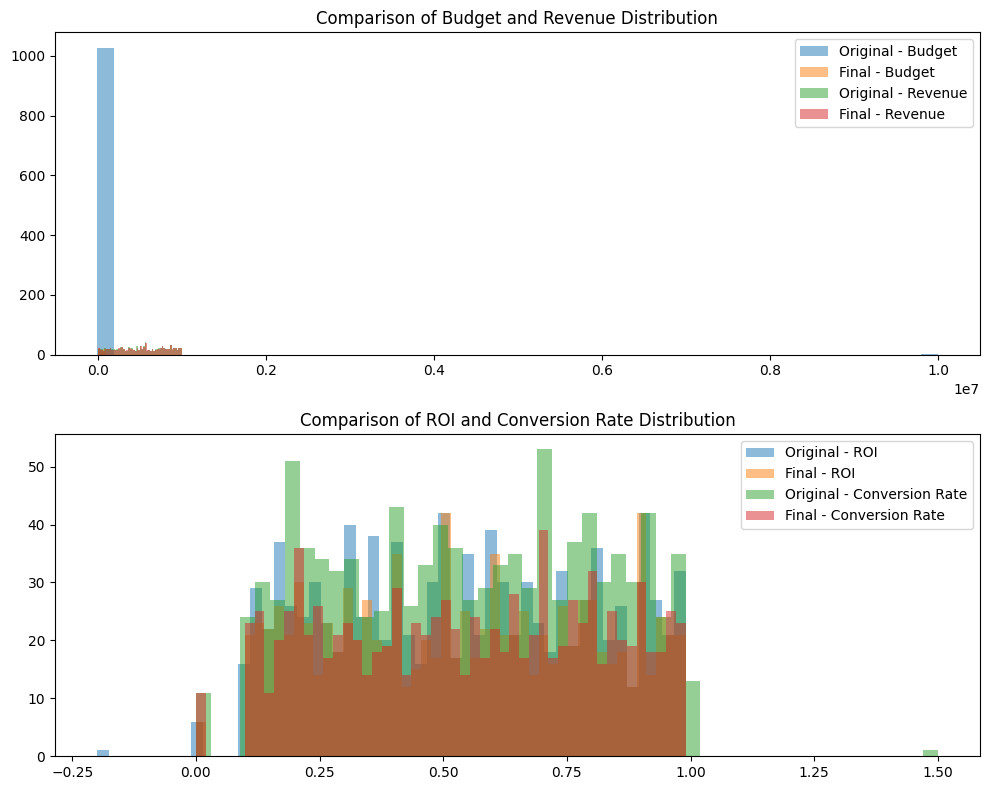

In [118]:
# And we will finish with some graphs

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].hist(df['budget'], alpha=0.5, label='Original - Budget', bins=50)
axs[0].hist(df5['budget'], alpha=0.5, label='Final - Budget', bins=50)
axs[0].hist(df['revenue'], alpha=0.5, label='Original - Revenue', bins=50)
axs[0].hist(df5['revenue'], alpha=0.5, label='Final - Revenue', bins=50)
axs[0].legend()
axs[0].set_title('Comparison of Budget and Revenue Distribution')

axs[1].hist(df['roi'], alpha=0.5, label='Original - ROI', bins=50)
axs[1].hist(df5['roi'], alpha=0.5, label='Final - ROI', bins=50)
axs[1].hist(df['conversion_rate'], alpha=0.5, label='Original - Conversion Rate', bins=50)
axs[1].hist(df5['conversion_rate'], alpha=0.5, label='Final - Conversion Rate', bins=50)
axs[1].legend()
axs[1].set_title('Comparison of ROI and Conversion Rate Distribution')

plt.tight_layout()
plt.show()

We can see in the graphs the distributions has not dramatically changed while the ouliers have been removed.

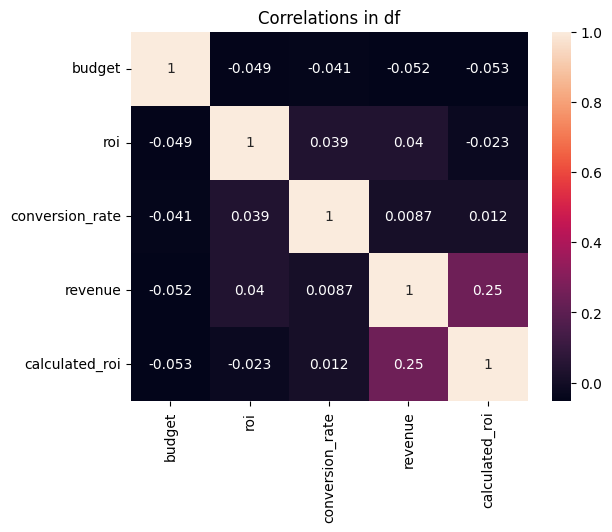

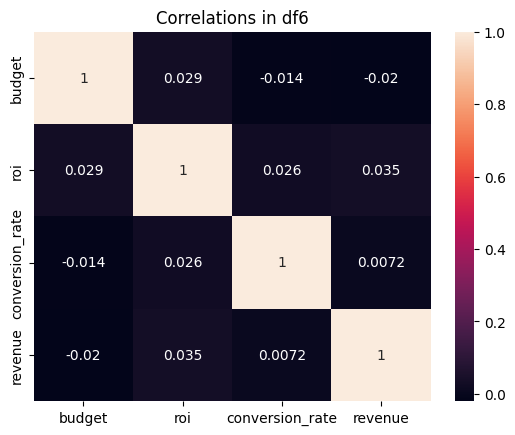

In [119]:
df_numeric = df.select_dtypes(include=['number'])
df5_numeric = df5.select_dtypes(include=['number'])

sns.heatmap(df_numeric.corr(), annot=True)
plt.title('Correlations in df')
plt.show()

sns.heatmap(df5_numeric.corr(), annot=True)
plt.title('Correlations in df6')
plt.show()

The correlation between revenue and budget has increased, which makes sense.
On the other hand, the correlation between ROI and conversion rate has decreased, which would only make sense if we recall that we have removed one extremely high outlier from the conversion rate.

So now we have check all changes done are right, let's move forward and calculate some extra values.

In [ ]:
# Let's calculate the Net Profit
df5['net_profit'] = df5['revenue'] - df5['budget']


In [120]:
#Let's add some seasonal columns
df5['year_start'] = df5['start_date'].dt.year
df5['month_start'] = df5['start_date'].dt.month
df5['quarter_start'] = df5['start_date'].dt.quarter
df5['year_end'] = df5['end_date'].dt.year
df5['month_end'] = df5['end_date'].dt.month
df5['quarter_end'] = df5['end_date'].dt.quarter


In [121]:
# We will add some categories for roi and conversion columns
roi_bins = [-float('inf'), 0.2, 0.5, float('inf')]
roi_labels = ['Low', 'Medium', 'High']
df5['roi_category'] = pd.cut(df5['roi'], bins=roi_bins, labels=roi_labels)

conversion_bins = [-float('inf'), 0.3, 0.7, float('inf')]
conversion_labels = ['Low', 'Medium', 'High']
df5['conversion_category'] = pd.cut(df5['conversion_rate'], bins=conversion_bins, labels=conversion_labels)


Due to the fact we are missing data such as the number of conversion, number of visitors/clicks.. we cannot elaborate more metrics.

In [122]:
df5['duration_days'] = (df5['end_date'] - df5['start_date']).dt.days

In [123]:
budget_75th = df5['budget'].quantile(0.75)
roi_75th = df5['roi'].quantile(0.75)
conversion_rate_75th = df5['conversion_rate'].quantile(0.75)
revenue_75th = df5['revenue'].quantile(0.75)

df5['high_budget_flag'] = (df5['budget'] > budget_75th).astype(int)
df5['high_roi_flag'] = (df5['roi'] > roi_75th).astype(int)
df5['high_conversion_rate_flag'] = (df5['conversion_rate'] > conversion_rate_75th).astype(int)
df5['high_revenue_flag'] = (df5['revenue'] > revenue_75th).astype(int)

In [124]:
df5.dtypes

campaign_name                        object
start_date                   datetime64[ns]
end_date                     datetime64[ns]
budget                              float64
roi                                 float64
type                                 object
target_audience                      object
channel                              object
conversion_rate                     float64
revenue                             float64
year_start                            int32
month_start                           int32
quarter_start                         int32
year_end                              int32
month_end                             int32
quarter_end                           int32
roi_category                       category
conversion_category                category
duration_days                         int64
high_budget_flag                      int64
high_roi_flag                         int64
high_conversion_rate_flag             int64
high_revenue_flag               

In [125]:
df5

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue,...,year_end,month_end,quarter_end,roi_category,conversion_category,duration_days,high_budget_flag,high_roi_flag,high_conversion_rate_flag,high_revenue_flag
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48,...,2024,2,1,Medium,Medium,328,0,0,0,0
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10,...,2024,4,2,High,Medium,432,0,0,0,0
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42,...,2023,10,4,Medium,Low,295,1,0,0,0
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73,...,2023,9,3,Medium,Low,366,0,0,0,0
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35,...,2024,5,2,Medium,High,313,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,email,B2C,promotion,0.52,206241.46,...,2023,12,4,Medium,Medium,339,0,0,0,0
998,Typo in Date,2024-01-13,2024-03-01,50000.00,0.65,webinar,B2C,promotion,0.90,320000.00,...,2024,3,1,High,High,48,0,0,1,0
999,Duplicate Campaign,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48,...,2024,2,1,Medium,Medium,328,0,0,0,0
1000,Future campaign,2025-01-01,2025-06-01,75000.00,0.90,webinar,B2C,promotion,0.65,200000.00,...,2025,6,2,High,Medium,151,1,1,0,0
